This Notebook contains my experiments with training Neural Cellular Automata, NCA, for style transfer. This is an early prototype and as a result, the code is a bit messy, uncommented and there are many more things to try to optimize and improve this method and code. 

I would like to thank the following people for their ideas and code that has been instrumental in making this work!

I would like to thank Alexander Mordvintsev, Ettore Randazzo, Eyvind Niklasson, Michael Levin (hopefully I did not miss anyone) for coming up with NCAs and for providing the code that forms the backbone of this notebook. If you see messy code, it is likely something I added. Since most of the code stems from them, I added their license. For more on NCAs check out their wonderful distill publications on the topic. https://distill.pub/2020/selforg/

I would also like to thank Katherine Crowson since the content loss and style loss code stems partially from her implementation of "A Neural Algorithm of Artistic Style" Gatys et al. (2015)

By Magnus Petersen \\
https://twitter.com/Omorfiamorphism \\
magnuspetersen@live.de 

Original license: \\
Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Imports and Notebook Utilities
%%capture
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import cv2
import sys
import numbers
import math
from functools import partial

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.models as models
from torchvision import transforms

torch.set_default_tensor_type('torch.cuda.FloatTensor')

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

def loss_plot():
  if len(style_log) > 0:
    fig, ax = pl.subplots(4, 1, figsize=(9, 7), constrained_layout=True)
    fig.tight_layout()
    ax[0].plot(step, style_log, 'r.', alpha=1) 
    ax[0].set_yscale('log')
    ax[0].title.set_text('Style Loss')
    ax[0].yaxis.tick_right()

    ax[1].plot(step, content_log, 'b.', alpha=1)
    ax[1].set_yscale('log')
    ax[1].title.set_text('Content Loss')
    ax[1].yaxis.tick_right()

    ax[2].plot(step, overflow_log, 'k.', alpha=1) 
    ax[2].set_yscale('log')
    ax[2].title.set_text('Overflow Loss')
    ax[2].yaxis.tick_right()

    ax[3].plot(step, color_log, 'k.', alpha=1) 
    ax[3].set_yscale('log')
    ax[3].title.set_text('Color Loss')
    ax[3].yaxis.tick_right()    

    pl.show()
    
def create_video(path_or_url = "https://uploads3.wikiart.org/images/federico-zandomeneghi/lady-with-a-hat-1895.jpg", image_length = 512, frames = 200, steps_per_frame = 1, end_speed_up = 6, channel = 3):
  with VideoWriter() as vid, torch.no_grad():
    x = ca.sample(path_or_url, sz=image_length)
    img = (x[0][...,channel:(channel+3),:,:]+0.5).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 1))
    for k in tnrange(frames, leave=False):
      step_n = max(int(end_speed_up*k/frames), steps_per_frame)
      for i in range(step_n):
        x[::, 3:] = ca(x)
      img = (x[0][...,channel:(channel+3),:,:]+0.5).permute(1, 2, 0).cpu()
      vid.add(zoom(img, 1))
  
!nvidia-smi -L

In [2]:
#@title Losses and related functions


EPS = 1e-6
#Copyright 2021 Mahmoud Afifi.
#Mahmoud Afifi, Marcus A. Brubaker, and Michael S. Brown. "HistoGAN: 
#Controlling Colors of GAN-Generated and Real Images via Color Histograms." 
#In CVPR, 2021.
#Implemetation source https://github.com/computer-vision2022/PAMA/tree/eef6e808bd6f4111deb818ce185b071137d2296d 


class RGBuvHistBlock(nn.Module):
  def __init__(self, h=64, insz=150, resizing='interpolation',
               method='inverse-quadratic', sigma=0.02, intensity_scale=True,
               device='cuda'):
    """ Computes the RGB-uv histogram feature of a given image.
    Args:
      h: histogram dimension size (scalar). The default value is 64.
      insz: maximum size of the input image; if it is larger than this size, the 
        image will be resized (scalar). Default value is 150 (i.e., 150 x 150 
        pixels).
      resizing: resizing method if applicable. Options are: 'interpolation' or 
        'sampling'. Default is 'interpolation'.
      method: the method used to count the number of pixels for each bin in the 
        histogram feature. Options are: 'thresholding', 'RBF' (radial basis 
        function), or 'inverse-quadratic'. Default value is 'inverse-quadratic'.
      sigma: if the method value is 'RBF' or 'inverse-quadratic', then this is 
        the sigma parameter of the kernel function. The default value is 0.02.
      intensity_scale: boolean variable to use the intensity scale (I_y in 
        Equation 2). Default value is True.
    Methods:
      forward: accepts input image and returns its histogram feature. Note that 
        unless the method is 'thresholding', this is a differentiable function 
        and can be easily integrated with the loss function. As mentioned in the
         paper, the 'inverse-quadratic' was found more stable than 'RBF' in our 
         training.
    """
    super(RGBuvHistBlock, self).__init__()
    self.h = h
    self.insz = insz
    self.device = device
    self.resizing = resizing
    self.method = method
    self.intensity_scale = intensity_scale
    if self.method == 'thresholding':
      self.eps = 6.0 / h
    else:
      self.sigma = sigma

  def forward(self, x):
    x = torch.clamp(x, 0, 1)
    if x.shape[2] > self.insz or x.shape[3] > self.insz:
      if self.resizing == 'interpolation':
        x_sampled = F.interpolate(x, size=(self.insz, self.insz),
                                  mode='bilinear', align_corners=False)
      elif self.resizing == 'sampling':
        inds_1 = torch.LongTensor(
          np.linspace(0, x.shape[2], self.h, endpoint=False)).to(
          device=self.device)
        inds_2 = torch.LongTensor(
          np.linspace(0, x.shape[3], self.h, endpoint=False)).to(
          device=self.device)
        x_sampled = x.index_select(2, inds_1)
        x_sampled = x_sampled.index_select(3, inds_2)
      else:
        raise Exception(
          f'Wrong resizing method. It should be: interpolation or sampling. '
          f'But the given value is {self.resizing}.')
    else:
      x_sampled = x

    L = x_sampled.shape[0]  # size of mini-batch
    if x_sampled.shape[1] > 3:
      x_sampled = x_sampled[:, :3, :, :]
    X = torch.unbind(x_sampled, dim=0)
    hists = torch.zeros((x_sampled.shape[0], 3, self.h, self.h)).to(
      device=self.device)
    for l in range(L):
      I = torch.t(torch.reshape(X[l], (3, -1)))
      II = torch.pow(I, 2)
      if self.intensity_scale:
        Iy = torch.unsqueeze(torch.sqrt(II[:, 0] + II[:, 1] + II[:, 2] + EPS), 
                             dim=1)
      else:
        Iy = 1

      Iu0 = torch.unsqueeze(torch.log(I[:, 0] + EPS) - torch.log(I[:, 1] + EPS),
                            dim=1)
      Iv0 = torch.unsqueeze(torch.log(I[:, 0] + EPS) - torch.log(I[:, 2] + EPS),
                            dim=1)
      diff_u0 = abs(
        Iu0 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      diff_v0 = abs(
        Iv0 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      if self.method == 'thresholding':
        diff_u0 = torch.reshape(diff_u0, (-1, self.h)) <= self.eps / 2
        diff_v0 = torch.reshape(diff_v0, (-1, self.h)) <= self.eps / 2
      elif self.method == 'RBF':
        diff_u0 = torch.pow(torch.reshape(diff_u0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v0 = torch.pow(torch.reshape(diff_v0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u0 = torch.exp(-diff_u0)  # Radial basis function
        diff_v0 = torch.exp(-diff_v0)
      elif self.method == 'inverse-quadratic':
        diff_u0 = torch.pow(torch.reshape(diff_u0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v0 = torch.pow(torch.reshape(diff_v0, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u0 = 1 / (1 + diff_u0)  # Inverse quadratic
        diff_v0 = 1 / (1 + diff_v0)
      else:
        raise Exception(
          f'Wrong kernel method. It should be either thresholding, RBF,' 
          f' inverse-quadratic. But the given value is {self.method}.')
      diff_u0 = diff_u0.type(torch.float32)
      diff_v0 = diff_v0.type(torch.float32)
      a = torch.t(Iy * diff_u0)
      hists[l, 0, :, :] = torch.mm(a, diff_v0)

      Iu1 = torch.unsqueeze(torch.log(I[:, 1] + EPS) - torch.log(I[:, 0] + EPS),
                            dim=1)
      Iv1 = torch.unsqueeze(torch.log(I[:, 1] + EPS) - torch.log(I[:, 2] + EPS),
                            dim=1)
      diff_u1 = abs(
        Iu1 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      diff_v1 = abs(
        Iv1 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))

      if self.method == 'thresholding':
        diff_u1 = torch.reshape(diff_u1, (-1, self.h)) <= self.eps / 2
        diff_v1 = torch.reshape(diff_v1, (-1, self.h)) <= self.eps / 2
      elif self.method == 'RBF':
        diff_u1 = torch.pow(torch.reshape(diff_u1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v1 = torch.pow(torch.reshape(diff_v1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u1 = torch.exp(-diff_u1)  # Gaussian
        diff_v1 = torch.exp(-diff_v1)
      elif self.method == 'inverse-quadratic':
        diff_u1 = torch.pow(torch.reshape(diff_u1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v1 = torch.pow(torch.reshape(diff_v1, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u1 = 1 / (1 + diff_u1)  # Inverse quadratic
        diff_v1 = 1 / (1 + diff_v1)

      diff_u1 = diff_u1.type(torch.float32)
      diff_v1 = diff_v1.type(torch.float32)
      a = torch.t(Iy * diff_u1)
      hists[l, 1, :, :] = torch.mm(a, diff_v1)

      Iu2 = torch.unsqueeze(torch.log(I[:, 2] + EPS) - torch.log(I[:, 0] + EPS),
                            dim=1)
      Iv2 = torch.unsqueeze(torch.log(I[:, 2] + EPS) - torch.log(I[:, 1] + EPS),
                            dim=1)
      diff_u2 = abs(
        Iu2 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      diff_v2 = abs(
        Iv2 - torch.unsqueeze(torch.tensor(np.linspace(-3, 3, num=self.h)),
                              dim=0).to(self.device))
      if self.method == 'thresholding':
        diff_u2 = torch.reshape(diff_u2, (-1, self.h)) <= self.eps / 2
        diff_v2 = torch.reshape(diff_v2, (-1, self.h)) <= self.eps / 2
      elif self.method == 'RBF':
        diff_u2 = torch.pow(torch.reshape(diff_u2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v2 = torch.pow(torch.reshape(diff_v2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u2 = torch.exp(-diff_u2)  # Gaussian
        diff_v2 = torch.exp(-diff_v2)
      elif self.method == 'inverse-quadratic':
        diff_u2 = torch.pow(torch.reshape(diff_u2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_v2 = torch.pow(torch.reshape(diff_v2, (-1, self.h)),
                            2) / self.sigma ** 2
        diff_u2 = 1 / (1 + diff_u2)  # Inverse quadratic
        diff_v2 = 1 / (1 + diff_v2)
      diff_u2 = diff_u2.type(torch.float32)
      diff_v2 = diff_v2.type(torch.float32)
      a = torch.t(Iy * diff_u2)
      hists[l, 2, :, :] = torch.mm(a, diff_v2)

    # normalization
    hists_normalized = hists / (
        ((hists.sum(dim=1)).sum(dim=1)).sum(dim=1).view(-1, 1, 1, 1) + EPS)

    return hists_normalized

def calc_histogram_loss(input_hist, target_hist):
    histogram_loss = (1/np.sqrt(2.0) * (torch.sqrt(torch.sum(
        torch.pow(torch.sqrt(target_hist) - torch.sqrt(input_hist), 2)))) / 
        input_hist.shape[0])

    return histogram_loss

def gram_calculation(x, layers):
  grams = []
  for i, layer in enumerate(vgg19[:max(layers)+1]):
    x = layer(x)
    if i in layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def transfer_loss(grams_x, grams_y, weights):
  loss = 0.0
  j = 0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()*weights[j]
    j += 1
  return loss

def overflow_loss(x):
  return (x-x.clamp(-1.0, 1.0)).abs().sum()

In [3]:
#@title Neural CA
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

class CA(torch.nn.Module):
  def __init__(self, chn=18, hidden_n=90, blur_kernel=[3, 7, 15]):
    super().__init__()
    self.chn = chn
    self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, hidden_n, 1)
    self.w3 = torch.nn.Conv2d(hidden_n, chn-3, 1)

    self.blur_layers = nn.ModuleList()
    self.pad_size = []
    for i in blur_kernel:
      self.blur_layers.append(GaussianSmoothing(1, kernel_size=i, sigma=2))
      self.pad_size.append(int((i-1)/2))

    gain = 0.15
    self.w1.weight.data = self.w1.weight.data*gain
    self.w1.bias.data = self.w1.bias.data*gain
    self.w2.weight.data = self.w2.weight.data*gain
    self.w2.bias.data = self.w2.bias.data*gain
    self.w3.weight.data = self.w3.weight.data*gain
    self.w3.bias.data = self.w3.bias.data*gain

  def forward(self, x):
    filters = torch.stack([sobel_x, sobel_x.T, lap])
    y = perchannel_conv(x, filters)
    y = torch.concat((x, y), 1)
    y = torch.relu(self.w1(y))
    y = torch.relu(self.w2(y))
    y = self.w3(y)

    b, c, h, w = y.shape

    for i in range(len(self.pad_size)):
      p_sz = self.pad_size[i]
      pad_blur = F.pad(x[::, -(i+2)][::, None], (p_sz, p_sz, p_sz, p_sz), mode='circular')
      x[::, -(i+2):-(i+1)] = self.blur_layers[i](pad_blur)

    return x[::, 3:]+y

  def seed(self, n, sz=224):
    m = len(images)
    if n >= m:
      n = m
    start = torch.rand(n, self.chn, sz, sz)    
    idx = np.random.choice(len(images), n, replace=False)
    image_seed = images[idx].permute(0, 3, 1, 2)
    targets = target_encoding[idx]
    start[::, :3, ::, ::] = image_seed
    start[::, 3:6, ::, ::] = image_seed
    start -= 0.5 
    return start, targets

  def sample(self, image_url, sz=224):
    image = imread(image_url, max_size=sz)
    image_seed = to_nchw(image)
    start = torch.rand(1, self.chn, image_seed.shape[2], image_seed.shape[3])

    start[::, :3, ::, ::] = image_seed
    start[::, 3:6, ::, ::] = image_seed
    start -= 0.5 
    return start

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

def run_n(x):
  x[::, 3:] = ca(x)
  return x

def to_rgb(x, idx):
  return x[...,idx:(idx+3),:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 16125


In [7]:
#@title Select Training Dataset {vertical-output: true}

dropdown = 'mixed' #@param ["art", "pictures", "mixed"]

if dropdown == "art":
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18BrSN1ZqoRQBlcuU6f77M5VCQ2IrqS-x' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18BrSN1ZqoRQBlcuU6f77M5VCQ2IrqS-x" -O art_224.pt && rm -rf /tmp/cookies.txt
if dropdown == "pictures":
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1njF5STaYrnlziFYfKLa8Bcb5VjkGixXj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1njF5STaYrnlziFYfKLa8Bcb5VjkGixXj" -O pictures_224.pt && rm -rf /tmp/cookies.txt
if dropdown == "mixed":
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19m4_uOTbMCowhvLNhY_GbYIBEMQDuO8y' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19m4_uOTbMCowhvLNhY_GbYIBEMQDuO8y" -O mixed_224.pt && rm -rf /tmp/cookies.txt
clear_output()

vgg19 = models.vgg19(pretrained=True).features[:30]

layers = [1, 6, 11, 20, 22, 29]
style_weights = [256, 64, 16, 4, 1]
weight_sum = sum(abs(w) for w in style_weights)
style_weights = [w / weight_sum for w in style_weights]

content_layers = [22]
content_weigths = [1]

normalize_vgg = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
images = torch.load("/content/"+dropdown+"_224.pt")

with torch.no_grad():
  target_encoding = torch.zeros(size = (images.shape[0], 512, 512))
  for i in range(images.shape[0]):
    target_encoding[i] = gram_calculation(normalize_vgg(images[i].float().permute([2, 0, 1])[None]), content_layers)[0][0]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

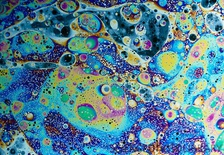

In [13]:
#@title Target image {vertical-output: true}

style_w = 0.4 #Ranges between 0.1 and 1 have been optimal in the past
content_w = 1
color_w = 2
size = 224
pool_size = 400

style_url = "https://i.pinimg.com/originals/be/df/9c/bedf9c6ea3ba180f2e99c69345f19638.jpg"
style_img = imread(style_url, max_size=size)

imshow(style_img)

In [14]:
#@title setup training
ca = CA()

opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1500, 3000, 4500], 0.3)

vgg19 = models.vgg19(pretrained=True).features[:30]

hist = RGBuvHistBlock(insz=64, h=256, 
                      intensity_scale=True, 
                      method='inverse-quadratic',
                      device=torch.device("cuda"))

with torch.no_grad():
  target_style = gram_calculation(normalize_vgg(to_nchw(style_img)), layers)
  target_style.pop(-2)
  target_hist = hist(torch.tensor(style_img).permute([2, 0, 1])[None])
  pool_images, pool_targets = ca.seed(pool_size)

clear_output()

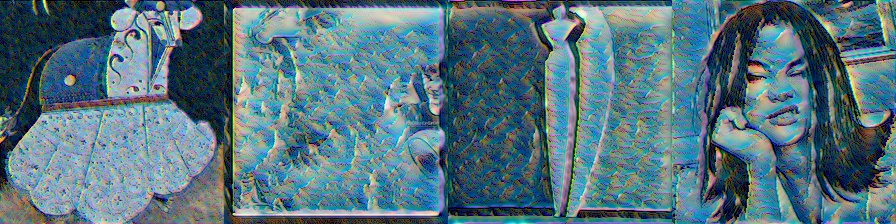

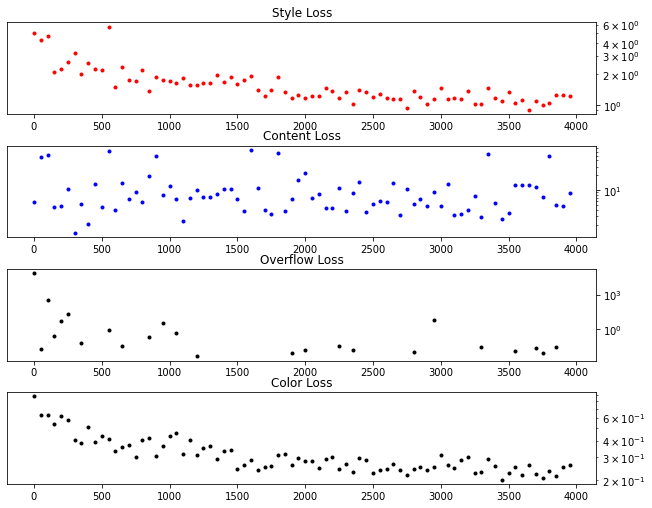

In [15]:
#@title training loop {vertical-output: true}
style_log = []
content_log = []
overflow_log = []
color_log = []
step = []

for i in range(4000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool_images), 4, replace=False)
    x = pool_images[batch_idx]
    target_content = pool_targets[batch_idx]
    if i%5 == 0:
      x[:1], target_content[:1] = ca.seed(1)
    target_content = [target_content]
  step_n = np.random.randint(32, 96)
  x = torch.utils.checkpoint.checkpoint_sequential([run_n]*step_n, 16, x)
  imgs = to_rgb(x, 3)

  over_loss = overflow_loss(x)

  grams = gram_calculation(normalize_vgg(imgs), layers)
  grams_content = grams.pop(-2)
  grams_style = grams
  content_loss = transfer_loss(grams_content, target_content, content_weigths)*content_w
  style_loss = transfer_loss(grams_style, target_style, style_weights)*style_w

  color_loss = calc_histogram_loss(hist(imgs), target_hist)*color_w

  loss = style_loss+content_loss+over_loss+color_loss

  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool_images[batch_idx] = x                
    pool_targets[batch_idx] = target_content[0]
    if i%50==0:
      style_log.append(style_loss.item())
      content_log.append(content_loss.item())
      overflow_log.append(over_loss.item())
      color_log.append(color_loss.item())
      step.append(i)

      clear_output(True)
      imgs = imgs.permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
      loss_plot()
      pl.show()

In [16]:
#@title NCA video {vertical-output: true}

path_or_url = "https://i.natgeofe.com/n/2a832501-483e-422f-985c-0e93757b7d84/6.jpg"
create_video(path_or_url = path_or_url, image_length = 1024, frames = 600,
             steps_per_frame = 1, end_speed_up = 6)

Output hidden; open in https://colab.research.google.com to view.